In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [2]:
from models.solar_power_nn import SolarPowerForecastingNN

In [3]:
def train_model(model, train_loader, num_epochs=100, damping=0.01, device='cpu'):
    model.to(device)
    model.train()

    loss_on_epoch = []

    for epoch in range(num_epochs):
        total_loss = 0.0
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)

            model.backward_lm(inputs, targets, damping=damping)

            outputs = model(inputs)
            batch_loss = torch.mean((outputs - targets) ** 2).item()
            total_loss += batch_loss

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.6f}")

        loss_on_epoch.append(avg_loss)

    return np.array(loss_on_epoch)

In [4]:
def test_model(model, test_loader, device='cpu'):
    model.to(device)
    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = torch.mean((outputs - targets) ** 2).item()
            total_loss += loss

    avg_loss = total_loss / len(test_loader)
    print(f"Test MSE: {avg_loss:.6f}")
    return avg_loss


# Dummy datasets

In [5]:
def create_dummy_dataset(num_samples=1000):
    """
    Create a dummy dataset for solar power forecasting.
    """
    # Generate random inputs
    solar_irradiance = torch.rand(num_samples, 3) * 1000  # W/m2
    time_features = torch.rand(num_samples, 3) * 24        # hours
    humidity = torch.rand(num_samples, 3) * 100             # %
    temperature = torch.rand(num_samples, 3) * 40 - 10      # Celsius (-10C to +30C)

    # Concatenate all inputs
    inputs = torch.cat([solar_irradiance, time_features, humidity, temperature], dim=1)  # Shape (N,12)

    # Simulate output: simple function (can be more complex)
    # Assume solar power roughly proportional to irradiance * efficiency
    efficiency = 0.15
    solar_power = efficiency * solar_irradiance[:, 0]  # take current irradiance
    solar_power = solar_power.unsqueeze(1)  # Shape (N,1)

    return inputs, solar_power

In [6]:
def create_dataloaders(batch_size=32, train_split=0.8):
    """
    Create training and testing dataloaders.
    """
    inputs, targets = create_dummy_dataset(num_samples=1200)

    # Train-test split
    num_train = int(train_split * len(inputs))
    train_inputs = inputs[:num_train]
    train_targets = targets[:num_train]
    test_inputs = inputs[num_train:]
    test_targets = targets[num_train:]

    # Create TensorDatasets
    train_dataset = TensorDataset(train_inputs, train_targets)
    test_dataset = TensorDataset(test_inputs, test_targets)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

In [7]:
# Create data
train_loader, test_loader = create_dataloaders(batch_size=32)

In [11]:
# for batch_idx, (inputs, targets) in enumerate(train_loader):
#     print(inputs)
#     print()
#     print(targets)
#     print()

In [13]:
# for inputs, targets in test_loader:
#     print(inputs)
#     print()
#     print(targets)
#     print()

In [14]:
# Instantiate model
model = SolarPowerForecastingNN()

In [15]:
# Train
loss_on_epoch = train_model(model, train_loader, num_epochs=30, damping=0.01)

Epoch 1/30, Loss: 802.988929
Epoch 2/30, Loss: 728.084971
Epoch 3/30, Loss: 802.139850
Epoch 4/30, Loss: 803.433828
Epoch 5/30, Loss: 794.629463
Epoch 6/30, Loss: 812.712606
Epoch 7/30, Loss: 780.305457
Epoch 8/30, Loss: 795.596439
Epoch 9/30, Loss: 797.806242
Epoch 10/30, Loss: 810.450843
Epoch 11/30, Loss: 779.553250
Epoch 12/30, Loss: 801.920543
Epoch 13/30, Loss: 802.595360
Epoch 14/30, Loss: 811.468436
Epoch 15/30, Loss: 797.648289
Epoch 16/30, Loss: 790.719799
Epoch 17/30, Loss: 787.948440
Epoch 18/30, Loss: 799.454430
Epoch 19/30, Loss: 775.220042
Epoch 20/30, Loss: 789.575339
Epoch 21/30, Loss: 805.422933
Epoch 22/30, Loss: 787.981498
Epoch 23/30, Loss: 798.087576
Epoch 24/30, Loss: 797.509717
Epoch 25/30, Loss: 811.924612
Epoch 26/30, Loss: 813.631690
Epoch 27/30, Loss: 778.752684
Epoch 28/30, Loss: 776.464374
Epoch 29/30, Loss: 822.201782
Epoch 30/30, Loss: 815.451010


In [16]:
# Test
test_mse = test_model(model, test_loader)

Test MSE: 1047.381310


# More realistic dummy datasets

In [7]:
def generate_realistic_solar_curve(times):
    """
    Generate realistic solar irradiance curve given time of day.
    times: tensor of shape (N,)
    Returns: tensor of solar irradiance values
    """
    # Adjust time to radians for the sine function
    solar_radians = (times - 6) * np.pi / 12
    solar_irradiance = torch.sin(solar_radians).clamp(min=0)  # no negative values
    solar_irradiance = solar_irradiance * 1000  # scale to 0-1000 W/m2
    return solar_irradiance

def create_realistic_dataset(num_samples=1000):
    """
    Create a realistic dummy dataset for solar power forecasting.
    """
    # Generate random time stamps (0-24 hours)
    current_time = torch.rand(num_samples) * 24  # (N,)

    # Generate realistic solar irradiance
    current_irradiance = generate_realistic_solar_curve(current_time)

    # Previous time steps (simple lagged versions)
    time_t_minus_1 = (current_time - 1) % 24
    time_t_minus_2 = (current_time - 2) % 24

    irradiance_t_minus_1 = generate_realistic_solar_curve(time_t_minus_1)
    irradiance_t_minus_2 = generate_realistic_solar_curve(time_t_minus_2)

    # Generate humidity (higher humidity at night/morning, random noise)
    humidity = 60 + 20 * torch.cos((current_time - 6) * np.pi / 12) + 10 * torch.randn(num_samples)
    humidity = humidity.clamp(20, 100)  # limit between 20% and 100%

    humidity_t_minus_1 = 60 + 20 * torch.cos((time_t_minus_1 - 6) * np.pi / 12) + 10 * torch.randn(num_samples)
    humidity_t_minus_1 = humidity_t_minus_1.clamp(20, 100)

    humidity_t_minus_2 = 60 + 20 * torch.cos((time_t_minus_2 - 6) * np.pi / 12) + 10 * torch.randn(num_samples)
    humidity_t_minus_2 = humidity_t_minus_2.clamp(20, 100)

    # Generate temperature (higher during the day)
    temperature = 10 + 15 * torch.sin((current_time - 6) * np.pi / 12) + 5 * torch.randn(num_samples)
    temperature = temperature.clamp(-10, 40)

    temperature_t_minus_1 = 10 + 15 * torch.sin((time_t_minus_1 - 6) * np.pi / 12) + 5 * torch.randn(num_samples)
    temperature_t_minus_1 = temperature_t_minus_1.clamp(-10, 40)

    temperature_t_minus_2 = 10 + 15 * torch.sin((time_t_minus_2 - 6) * np.pi / 12) + 5 * torch.randn(num_samples)
    temperature_t_minus_2 = temperature_t_minus_2.clamp(-10, 40)

    # Stack inputs
    inputs = torch.stack([
        current_irradiance, irradiance_t_minus_1, irradiance_t_minus_2,
        current_time, time_t_minus_1, time_t_minus_2,
        humidity, humidity_t_minus_1, humidity_t_minus_2,
        temperature, temperature_t_minus_1, temperature_t_minus_2
    ], dim=1)

    # Output: solar power = efficiency * current irradiance
    efficiency = 0.17  # 17% panel efficiency
    solar_power = efficiency * current_irradiance
    solar_power = solar_power.unsqueeze(1)

    return inputs, solar_power

def create_realistic_dataloaders(batch_size=32, train_split=0.8):
    """
    Create realistic training and testing dataloaders.
    """
    inputs, targets = create_realistic_dataset(num_samples=1200)

    num_train = int(train_split * len(inputs))
    train_inputs = inputs[:num_train]
    train_targets = targets[:num_train]
    test_inputs = inputs[num_train:]
    test_targets = targets[num_train:]

    train_dataset = TensorDataset(train_inputs, train_targets)
    test_dataset = TensorDataset(test_inputs, test_targets)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader


In [8]:
# Create more realistic data
train_loader, test_loader = create_realistic_dataloaders(batch_size=32)

In [9]:
# Train and test like before
model = SolarPowerForecastingNN()

In [10]:
loss_on_epoch = train_model(model, train_loader, num_epochs=30, damping=0.01)

Epoch 1/30, Loss: 1251.610429
Epoch 2/30, Loss: 441.066454
Epoch 3/30, Loss: 437.736956
Epoch 4/30, Loss: 430.466348
Epoch 5/30, Loss: 433.836020
Epoch 6/30, Loss: 432.512192
Epoch 7/30, Loss: 372.702459
Epoch 8/30, Loss: 403.141633
Epoch 9/30, Loss: 354.136084
Epoch 10/30, Loss: 354.269637
Epoch 11/30, Loss: 364.513119
Epoch 12/30, Loss: 325.630449
Epoch 13/30, Loss: 370.437575
Epoch 14/30, Loss: 387.191243
Epoch 15/30, Loss: 340.590069
Epoch 16/30, Loss: 356.395911
Epoch 17/30, Loss: 363.621657
Epoch 18/30, Loss: 359.024060
Epoch 19/30, Loss: 352.498945
Epoch 20/30, Loss: 354.080269
Epoch 21/30, Loss: 352.629123
Epoch 22/30, Loss: 366.229760
Epoch 23/30, Loss: 361.376634
Epoch 24/30, Loss: 341.892712
Epoch 25/30, Loss: 370.892181
Epoch 26/30, Loss: 347.347827
Epoch 27/30, Loss: 381.216007
Epoch 28/30, Loss: 322.112084
Epoch 29/30, Loss: 341.387239
Epoch 30/30, Loss: 348.530385


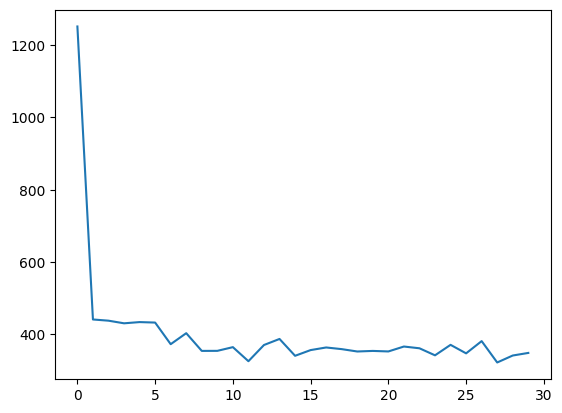

In [11]:
plt.plot(loss_on_epoch)

In [12]:
test_mse = test_model(model, test_loader)

Test MSE: 1227.541946


In [13]:
def plot_predictions_sorted_by_time(model, data_loader, device='cpu', title="Solar Power Prediction vs Target (Sorted by Time)"):
    """
    Plot model predictions vs true targets, sorted by time.
    """
    model.eval()
    inputs, targets = next(iter(data_loader))  # Take first batch
    inputs, targets = inputs.to(device), targets.to(device)

    with torch.no_grad():
        predictions = model(inputs)

    # Extract current time (it's feature index 3 according to input order!)
    current_time = inputs[:, 3].cpu().numpy()

    # Prepare everything for plotting
    targets = targets.squeeze().cpu().numpy()
    predictions = predictions.squeeze().cpu().numpy()

    # Sort by current time
    sorted_indices = current_time.argsort()
    current_time_sorted = current_time[sorted_indices]
    targets_sorted = targets[sorted_indices]
    predictions_sorted = predictions[sorted_indices]

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(current_time_sorted, targets_sorted, label='True Solar Power', color='blue', linewidth=2)
    plt.plot(current_time_sorted, predictions_sorted, label='Predicted Solar Power', color='orange', linestyle='--', linewidth=2)
    plt.title(title)
    plt.xlabel('Time of Day (hours)')
    plt.ylabel('Solar Power (W)')
    plt.legend()
    plt.grid(True)
    plt.show()



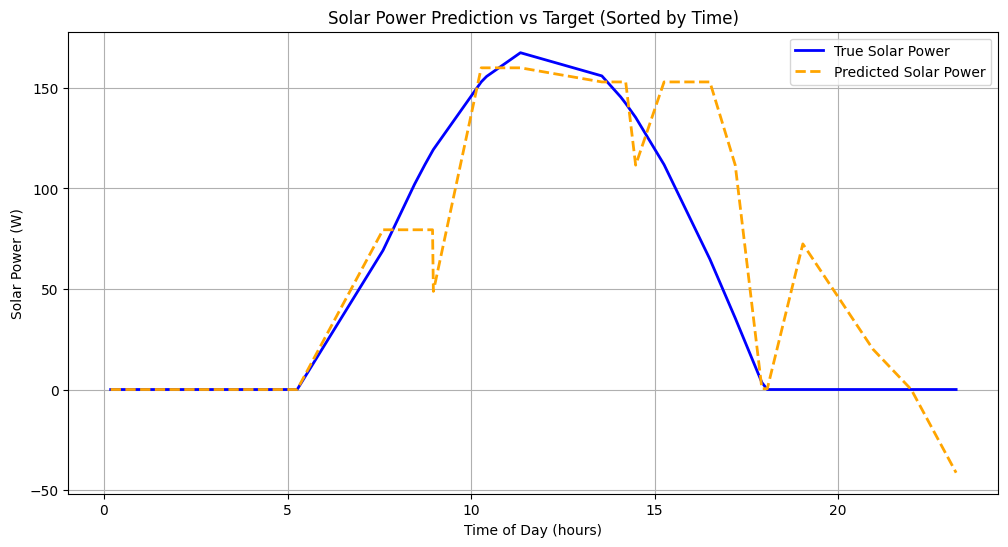

In [14]:
# After training
plot_predictions_sorted_by_time(model, test_loader)

In [15]:
def plot_predictions_colored_by_feature(model, data_loader, feature_index, feature_name="Humidity", device='cpu'):
    """
    Plot model predictions vs targets, colored by a secondary feature (e.g., humidity, temperature).
    """
    model.eval()
    inputs, targets = next(iter(data_loader))  # Take first batch
    inputs, targets = inputs.to(device), targets.to(device)

    with torch.no_grad():
        predictions = model(inputs)

    # Extract time and secondary feature
    current_time = inputs[:, 3].cpu().numpy()            # Feature index 3 = current time
    secondary_feature = inputs[:, feature_index].cpu().numpy()

    targets = targets.squeeze().cpu().numpy()
    predictions = predictions.squeeze().cpu().numpy()

    # Sort by time for better curve
    sorted_indices = current_time.argsort()
    current_time_sorted = current_time[sorted_indices]
    targets_sorted = targets[sorted_indices]
    predictions_sorted = predictions[sorted_indices]
    secondary_feature_sorted = secondary_feature[sorted_indices]

    # Plot
    plt.figure(figsize=(12, 6))
    sc1 = plt.scatter(current_time_sorted, targets_sorted, c=secondary_feature_sorted, cmap='coolwarm', label='True Solar Power', marker='o')
    sc2 = plt.scatter(current_time_sorted, predictions_sorted, c=secondary_feature_sorted, cmap='coolwarm', label='Predicted Solar Power', marker='x')

    plt.title(f"Solar Power Prediction vs Target (Colored by {feature_name})")
    plt.xlabel('Time of Day (hours)')
    plt.ylabel('Solar Power (W)')
    plt.colorbar(sc1, label=f"{feature_name}")
    plt.legend(['True Solar Power', 'Predicted Solar Power'])
    plt.grid(True)
    plt.show()

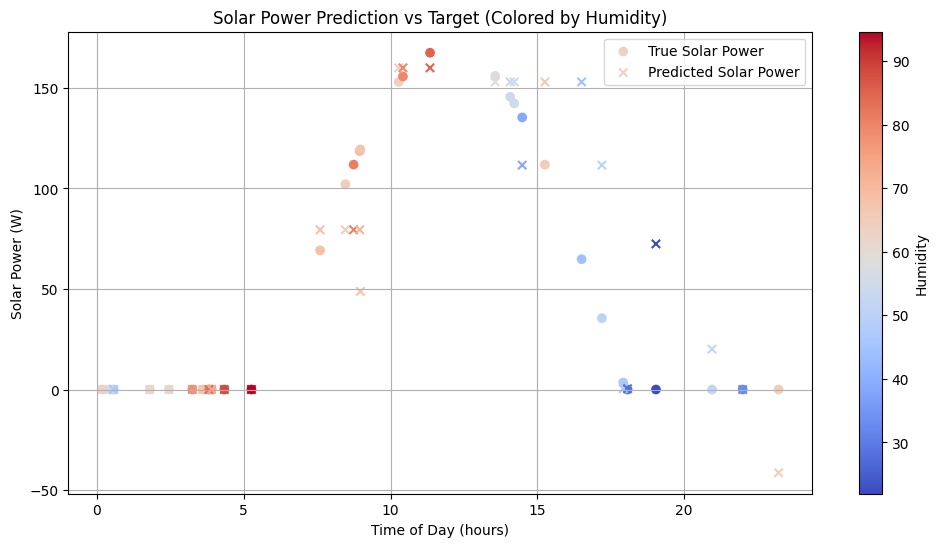

In [16]:
# Plot colored by humidity (input feature 6: current humidity)
plot_predictions_colored_by_feature(model, test_loader, feature_index=6, feature_name="Humidity")

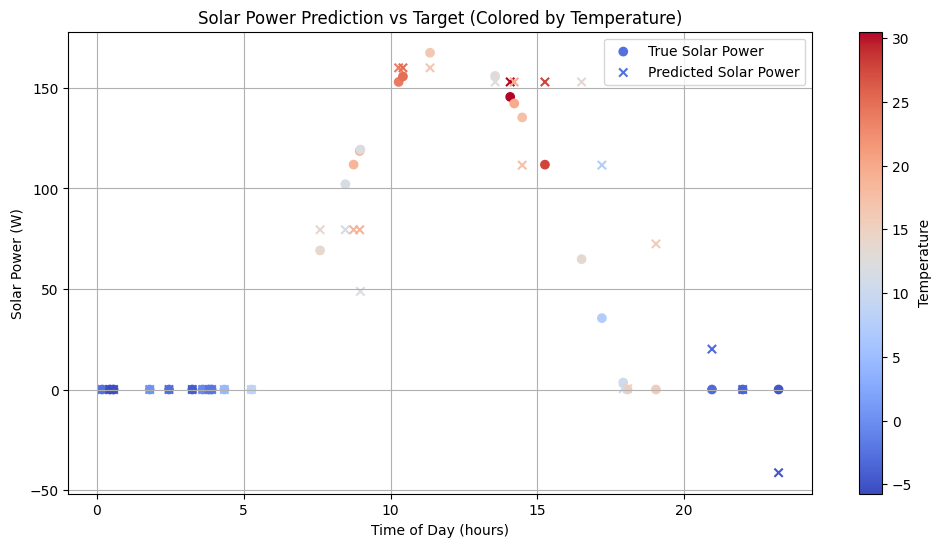

In [17]:
# or Plot colored by temperature (input feature 9: current temperature)
plot_predictions_colored_by_feature(model, test_loader, feature_index=9, feature_name="Temperature")

In [18]:
def plot_prediction_error_colored_by_feature(model, data_loader, feature_index, feature_name="Humidity", device='cpu'):
    """
    Plot model prediction error (prediction - target), colored by a secondary feature (e.g., humidity, temperature).
    """
    model.eval()
    inputs, targets = next(iter(data_loader))  # Take first batch
    inputs, targets = inputs.to(device), targets.to(device)

    with torch.no_grad():
        predictions = model(inputs)

    # Extract time and secondary feature
    current_time = inputs[:, 3].cpu().numpy()            # Feature index 3 = current time
    secondary_feature = inputs[:, feature_index].cpu().numpy()

    targets = targets.squeeze().cpu().numpy()
    predictions = predictions.squeeze().cpu().numpy()

    # Compute error
    errors = predictions - targets

    # Sort by time for nicer plot
    sorted_indices = current_time.argsort()
    current_time_sorted = current_time[sorted_indices]
    errors_sorted = errors[sorted_indices]
    secondary_feature_sorted = secondary_feature[sorted_indices]

    # Plot
    plt.figure(figsize=(12, 6))
    scatter = plt.scatter(current_time_sorted, errors_sorted, c=secondary_feature_sorted, cmap='coolwarm', marker='o')
    plt.title(f"Prediction Error (Predicted - True) Colored by {feature_name}")
    plt.xlabel('Time of Day (hours)')
    plt.ylabel('Prediction Error (W)')
    plt.colorbar(scatter, label=f"{feature_name}")
    plt.axhline(0, color='black', linestyle='--')  # zero error line
    plt.grid(True)
    plt.show()

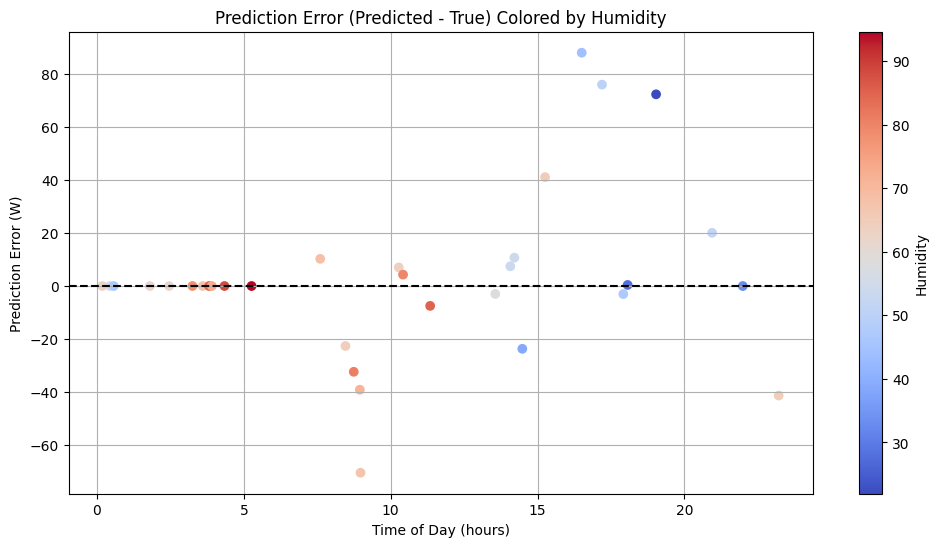

In [19]:
# Error plot colored by humidity
plot_prediction_error_colored_by_feature(model, test_loader, feature_index=6, feature_name="Humidity")

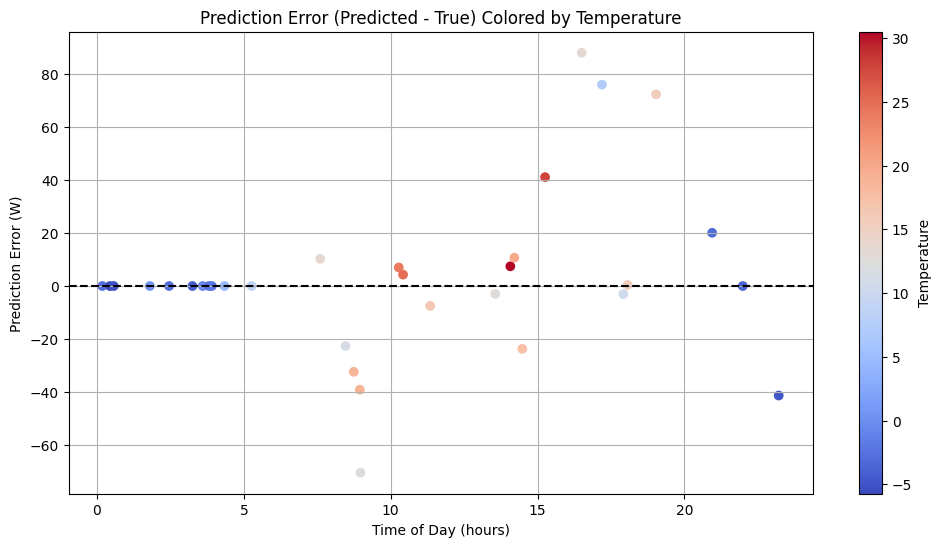

In [20]:
# Error plot colored by temperature
plot_prediction_error_colored_by_feature(model, test_loader, feature_index=9, feature_name="Temperature")

In [21]:
def plot_binned_error(model, data_loader, feature_index, feature_name="Humidity", bins=10, device='cpu'):
    """
    Bin a secondary feature (e.g., humidity) and plot average prediction error in each bin.
    """
    model.eval()
    inputs, targets = next(iter(data_loader))  # Take first batch
    inputs, targets = inputs.to(device), targets.to(device)

    with torch.no_grad():
        predictions = model(inputs)

    # Extract secondary feature
    secondary_feature = inputs[:, feature_index].cpu().numpy()
    targets = targets.squeeze().cpu().numpy()
    predictions = predictions.squeeze().cpu().numpy()

    # Compute prediction errors
    errors = predictions - targets

    # Bin the secondary feature
    bin_edges = np.linspace(np.min(secondary_feature), np.max(secondary_feature), bins+1)
    bin_indices = np.digitize(secondary_feature, bin_edges) - 1  # bins are 0-indexed

    # Compute mean error per bin
    mean_errors = []
    bin_centers = []
    for i in range(bins):
        bin_mask = (bin_indices == i)
        if np.any(bin_mask):
            mean_errors.append(errors[bin_mask].mean())
            bin_centers.append((bin_edges[i] + bin_edges[i+1]) / 2)

    # Plot
    plt.figure(figsize=(10, 5))
    plt.bar(bin_centers, mean_errors, width=(bin_edges[1]-bin_edges[0])*0.8, color='skyblue', edgecolor='black')
    plt.title(f"Average Prediction Error by {feature_name} Bins")
    plt.xlabel(f"{feature_name}")
    plt.ylabel("Prediction Error (W)")
    plt.axhline(0, color='black', linestyle='--')
    plt.grid(True)
    plt.show()

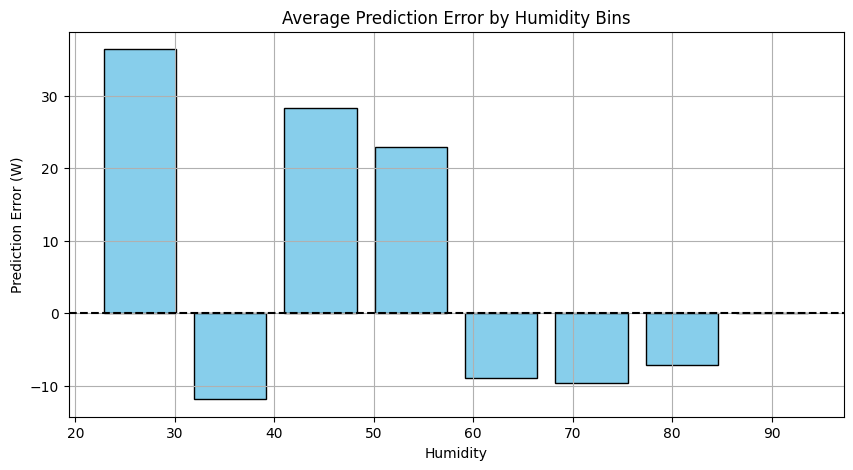

In [22]:
# Average error per humidity bin
plot_binned_error(model, test_loader, feature_index=6, feature_name="Humidity", bins=8)

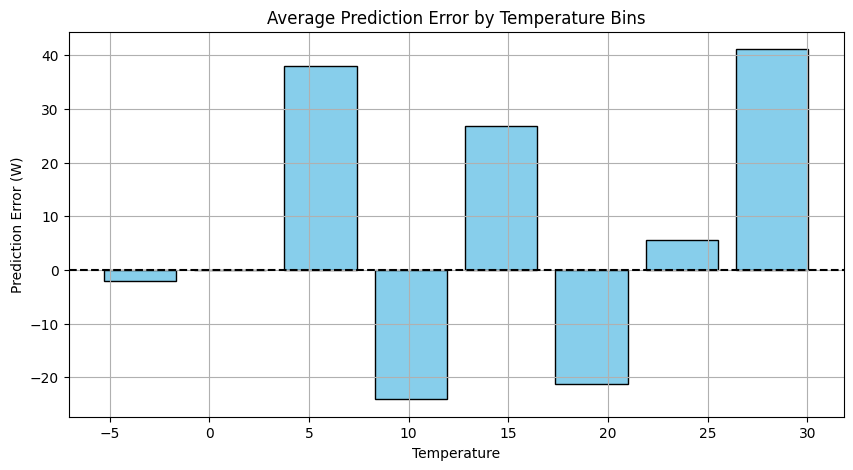

In [23]:
# Average error per temperature bin
plot_binned_error(model, test_loader, feature_index=9, feature_name="Temperature", bins=8)

In [25]:
def dataloader_to_dataframe(data_loader, feature_names=None, device='cpu'):
    """
    Convert one batch from a DataLoader into a Pandas DataFrame.
    
    Args:
        data_loader: PyTorch DataLoader
        feature_names: Optional list of feature names (length must match input dimension)
        device: device to move tensors if needed
    Returns:
        df: Pandas DataFrame containing inputs and targets
    """
    # Get first batch
    inputs, targets = next(iter(data_loader))
    inputs, targets = inputs.to(device), targets.to(device)

    # Move to CPU and convert to numpy
    inputs_np = inputs.cpu().numpy()
    targets_np = targets.squeeze().cpu().numpy()

    # Build column names
    n_features = inputs_np.shape[1]
    if feature_names is None:
        feature_names = [f"Feature_{i}" for i in range(n_features)]

    # Create DataFrame
    df = pd.DataFrame(inputs_np, columns=feature_names)
    df['Target'] = targets_np

    return df


In [27]:
# Suppose you already have a train_loader and a test_loader

# Define feature names (optional, but recommended for clarity)
feature_names = [
    'Irradiance(t)', 'Irradiance(t-1)', 'Irradiance(t-2)',
    'Time(t)', 'Time(t-1)', 'Time(t-2)',
    'Humidity(t)', 'Humidity(t-1)', 'Humidity(t-2)',
    'Temperature(t)', 'Temperature(t-1)', 'Temperature(t-2)'
]

# Convert one batch
df_train = dataloader_to_dataframe(train_loader, feature_names)
df_test = dataloader_to_dataframe(test_loader, feature_names)



In [29]:
df_train.head()

,Irradiance(t),Irradiance(t-1),Irradiance(t-2),Time(t),Time(t-1),Time(t-2),Humidity(t),Humidity(t-1),Humidity(t-2),Temperature(t),Temperature(t-1),Temperature(t-2),Target
0,0.000000,0.000000,0.000000,20.774281,19.774281,18.774281,46.242771,30.658161,47.672413,-8.657391,5.538497,8.390212,0.000000
1,954.614868,844.999695,677.799194,10.844793,9.844793,8.844793,70.449516,65.543137,72.837143,32.260590,21.851732,24.464417,162.284531
2,0.000000,0.000000,0.000000,2.984342,1.984342,0.984342,85.145554,61.899666,65.293877,-2.780457,-5.833050,-10.000000,0.000000
3,0.000000,0.000000,0.000000,2.212426,1.212426,0.212426,64.320709,75.298828,51.917152,-7.803880,4.779248,-9.313288,0.000000
4,0.000000,0.000000,0.000000,3.350462,2.350462,1.350462,48.211945,57.617798,56.123363,6.968265,-0.882015,-3.840151,0.000000
